In [1]:
import lightgbm as lgb
import optuna.visualization as vis

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import seaborn as sns

In [3]:
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)

Seaborn version: 0.13.2
Matplotlib version: 3.10.3


In [4]:
filepath = '../../split_year_data'

### Encoding Countries

In [22]:
merged = pd.DataFrame(pd.read_pickle('../../raw_merged_data_v2_withinyears'))
missing_dropped = merged.dropna(axis=1, how='all', ignore_index=True)
rdrop = missing_dropped.dropna(axis=0, how='all', ignore_index=True)
ydrop = missing_dropped.dropna(subset=['Maternal mortality ratio (national estimate, per 100,000 live births)'])

In [24]:
countries = ydrop['setting'].unique()
countries_dict = {}
count = 0
for c in countries:
    countries_dict[c] = count
    count += 1

In [28]:
import pickle 

with open('../../split_year_data/countries_dict.pkl', 'wb') as f:
    pickle.dump(countries_dict, f)

### Loading Datasets

In [5]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [6]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [7]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

### Objective Function

In [8]:
def objective(trial, x_train, y_train, x_val, y_val):

    n_trees = trial.suggest_int("number_trees", 10, 300)

    max_depth = trial.suggest_int("max_tree_depth", 3, 25)

    boosting_type = trial.suggest_categorical("boosting_type", ['gbdt', 'dart'])
    
    bagging_fraction = trial.suggest_float("bagging_fraction", 0.1, 1.0)
    bagging_freq = trial.suggest_int("bagging_freq", 0, 10)

    learning_rate = trial.suggest_float("learning_rate", 0, 1)
    l1_norm = trial.suggest_float("l1_norm", 0, 0.001)
    l2_norm = trial.suggest_float("l2_norm", 0, 0.001)

    lgbm_model = lgb.LGBMRegressor(random_state=42, verbosity = -1, n_estimators=n_trees, boosting=boosting_type, max_depth=max_depth, learning_rate=learning_rate, reg_alpha=l1_norm, reg_lambda=l2_norm, bagging_fraction=bagging_fraction, bagging_freq=bagging_freq)
    trained_model = lgbm_model.fit(x_train, y_train)
    y_pred = trained_model.predict(x_val)
    val_loss = mean_squared_error(y_pred, y_val)

    return val_loss  # Optuna minimizes this

### Model Iteration

#### Code Design

#### Code Implementation

In [9]:
output_dir = '../../split_year_models/lightgbm'

In [10]:
#because lightgbm cannot handle the comma
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    val_label = validation[fold][1].copy()
    val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx != 2:
            continue
        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh_idx * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_input_data, val_label), n_trials=300)
        best_model = lgb.LGBMRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'lightgbm',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-07-24 14:32:29,082] A new study created in memory with name: no-name-b4c7a113-0a71-4842-bb70-653fe92e46a3
[I 2025-07-24 14:32:33,920] Trial 0 finished with value: 3223.4516430881404 and parameters: {'number_trees': 128, 'max_tree_depth': 16, 'boosting_type': 'dart', 'bagging_fraction': 0.2709229841306753, 'bagging_freq': 4, 'learning_rate': 0.47884509509965045, 'l1_norm': 0.0001766042330478992, 'l2_norm': 0.000803580549171834}. Best is trial 0 with value: 3223.4516430881404.
[I 2025-07-24 14:32:38,691] Trial 1 finished with value: 8884.207059524075 and parameters: {'number_trees': 267, 'max_tree_depth': 7, 'boosting_type': 'gbdt', 'bagging_fraction': 0.5974519372206659, 'bagging_freq': 3, 'learning_rate': 0.9636027174268826, 'l1_norm': 0.0006282470908017129, 'l2_norm': 0.0008805941015144997}. Best is trial 0 with value: 3223.4516430881404.
[I 2025-07-24 14:32:45,375] Trial 2 finished with value: 2739.3517257942754 and parameters: {'number_trees': 234, 'max_tree_depth': 16, 'boo

Now looking at instances where data has been dropped due to the missing data thresholds

In [11]:
#because lightgbm cannot handle the comma
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    val_label = validation[fold][1].copy()
    val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx == 2:
            continue

        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh_idx * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_relevant_input, val_label), n_trials=300)
        best_model = lgb.LGBMRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'lightgbm',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-07-24 15:22:47,990] A new study created in memory with name: no-name-cbd31735-5e24-4cda-a427-888f6c282007
[I 2025-07-24 15:22:48,423] Trial 0 finished with value: 12872.933674955344 and parameters: {'number_trees': 210, 'max_tree_depth': 3, 'boosting_type': 'gbdt', 'bagging_fraction': 0.9948415312490518, 'bagging_freq': 10, 'learning_rate': 0.6803677465985813, 'l1_norm': 0.0009193549904852664, 'l2_norm': 0.0009285681823378032}. Best is trial 0 with value: 12872.933674955344.
[I 2025-07-24 15:22:49,264] Trial 1 finished with value: 30940.709445120046 and parameters: {'number_trees': 209, 'max_tree_depth': 7, 'boosting_type': 'gbdt', 'bagging_fraction': 0.6733761306836203, 'bagging_freq': 6, 'learning_rate': 0.6851597977595935, 'l1_norm': 0.0005430366401510872, 'l2_norm': 0.0007616167716916344}. Best is trial 0 with value: 12872.933674955344.
[I 2025-07-24 15:22:49,398] Trial 2 finished with value: 9382.00641180029 and parameters: {'number_trees': 73, 'max_tree_depth': 3, 'boosti

### Loading Models

In [12]:
output_dir = '../../split_year_models/lightgbm'

#### Test values for all models

In [13]:
# setting up the dataframe to hold test results
index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)
test_stats = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

test_stats

MAPE  MAE  MSE RMSE   R2
Missing Data Threshold Fold                         
Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
None                   1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN

In [14]:
test_data_y.iloc[0] + 5

Maternal mortality ratio (national estimate, per 100,000 live births)    456.0
Name: 0, dtype: float64

In [15]:
best_parameters = {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []}

In [16]:
test_data_x['setting'] = test_data_x['setting'].astype("category")
testing_x = test_data_x.copy()
testing_x.columns = testing_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")
        best_parameters[thresh_name].append(best_params)
        best_model = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = testing_x.columns.intersection(train_input_data.columns)
        to_test = testing_x[columns_needed].copy()

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(prediction, test_data_y)
        mae = mean_absolute_error(prediction, test_data_y)
        rmse = np.sqrt(mse)
        r2 = r2_score(prediction, test_data_y)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        mape = mape/num_predictions
        #mape = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), 'MSE'] = mse
        test_stats.loc[(thresh_name, fold_num), 'MAE'] = mae
        test_stats.loc[(thresh_name, fold_num), 'RMSE'] = rmse
        test_stats.loc[(thresh_name, fold_num), 'R2'] = r2
        test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_83311/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_83311/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_83311/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

In [17]:
test_stats

MAPE        MAE          MSE       RMSE  \
Missing Data Threshold Fold                                                
Threshold 85%          1     0.438449   30.51159  7841.059447  88.549757   
                       2     0.401615  30.996605  8903.647005  94.359138   
                       3     0.547375  33.952318  7744.245743  88.001396   
                       4     0.618929  40.126473   7891.66357  88.835036   
                       5     0.536229   31.46316  7423.074017  86.157263   
Threshold 95%          1     0.395491  26.695867  5307.504444  72.852621   
                       2     0.646141  35.519957  7497.743534  86.589512   
                       3     0.474997   27.45197  5790.262685  76.093776   
                       4     0.369388  24.924865  5291.879408  72.745305   
                       5     0.430699  23.744151   5081.54539  71.284959   
None                   1     0.368815  27.756175  7584.522995  87.089167   
                       2      0.39237  25.083838  4528.872848  67.296901   
                       3     0.475605  28.175377  5625.458082  75.003054   
                       4     0.408137  29.860676  7346.847346  85.713752   
                       5     0.625181   37.36022  6304.160666  79.398745   

                                   R2  
Missing Data Threshold Fold            
Threshold 85%          1     0.453876  
                       2     0.195753  
                       3     0.607581  
                       4     0.623221  
                       5     0.626044  
Threshold 95%          1     0.687578  
                       2     0.607066  
                       3     0.742133  
                       4     0.751692  
                       5     0.779395  
None                   1     0.448181  
                       2     0.794973  
                       3     0.737201  
                       4     0.478478  
                       5     0.729431

In [18]:
mean_summary = test_stats.groupby(level='Missing Data Threshold').mean()
mean_summary = mean_summary.astype('float')
mean_summary = mean_summary.round(2)
std_summary = test_stats.groupby(level='Missing Data Threshold').std()
std_summary = std_summary.astype('float')
std_summary = std_summary.round(2)

In [19]:
# setting up the dataframe to hold summary of cross-fold validation results
summary_index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

summary_stats = pd.DataFrame(index=['Threshold 85%', 'Threshold 95%', 'None'], columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

for thresh_idx, thresh in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
    for metric_idx, metric in enumerate(['MAPE', 'MAE', 'MSE', 'RMSE', 'R2']):
        summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])

summary_stats

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_83311/2971279602.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_83311/2971279602.py:13: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])


,MAPE,MAE,MSE,RMSE,R2
Threshold 85%,0.45 +- 0.1,29.65 +- 4.64,6277.97 +- 1258.51,78.9 +- 8.12,0.64 +- 0.16
Threshold 95%,0.51 +- 0.09,33.41 +- 3.98,7960.74 +- 557.7,89.18 +- 3.08,0.5 +- 0.19
None,0.46 +- 0.11,27.67 +- 4.63,5793.79 +- 987.31,75.91 +- 6.22,0.71 +- 0.07


#### Best Parameters

#### Visualisation

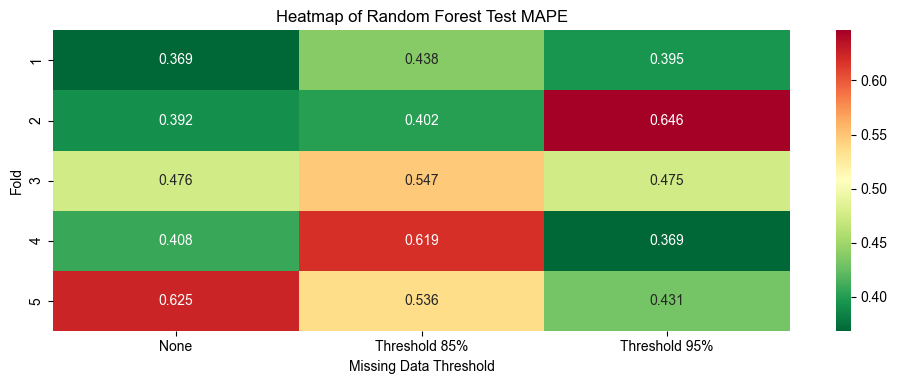

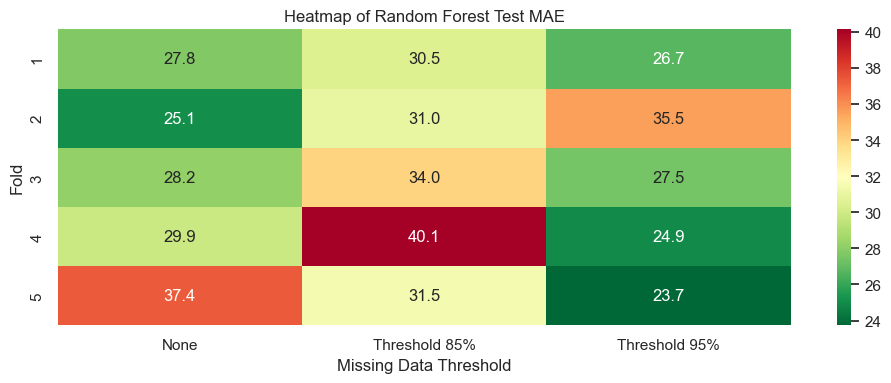

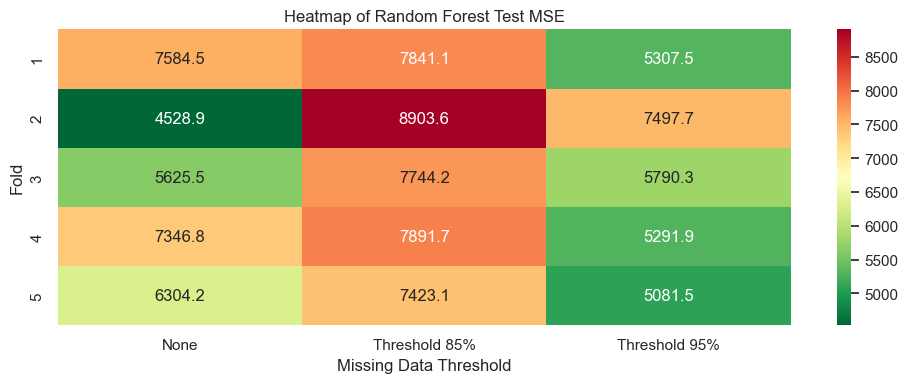

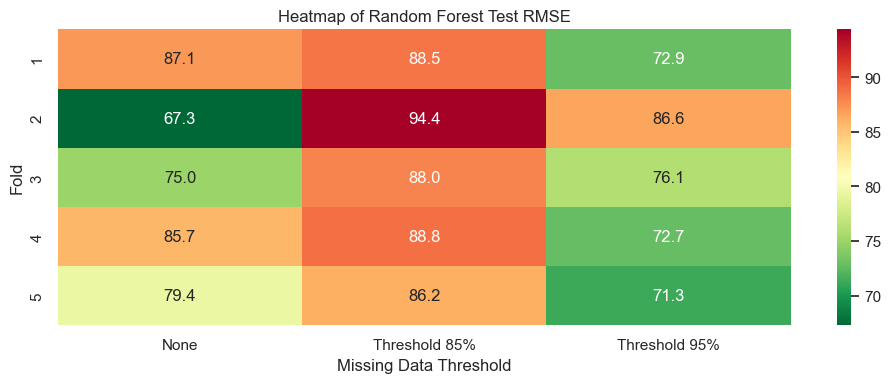

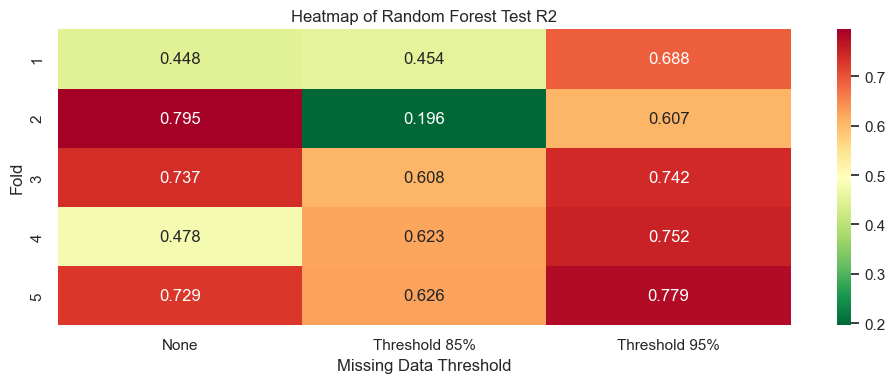

In [20]:
import seaborn as sns

data = test_stats.astype(float)

for metric in data.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric)
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

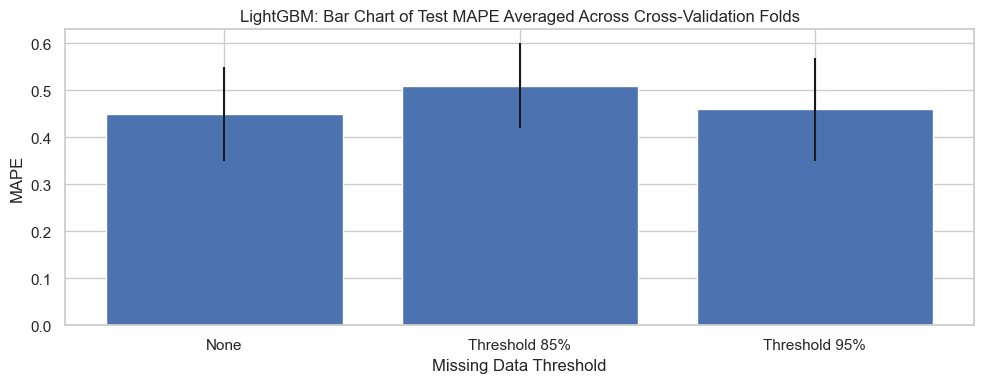

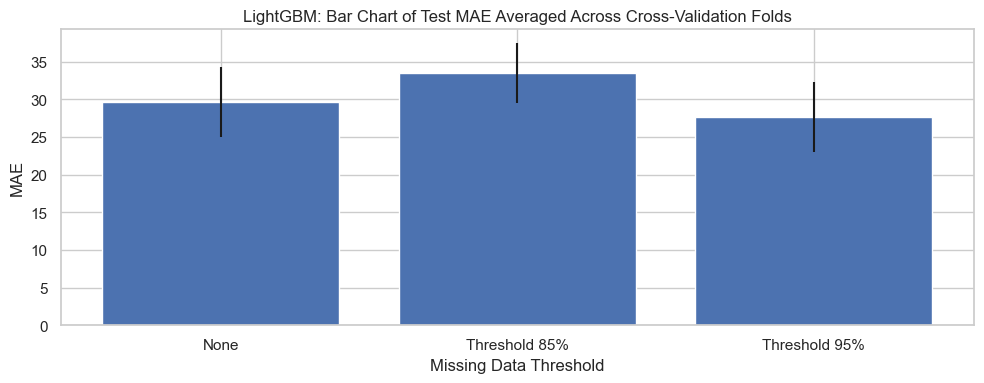

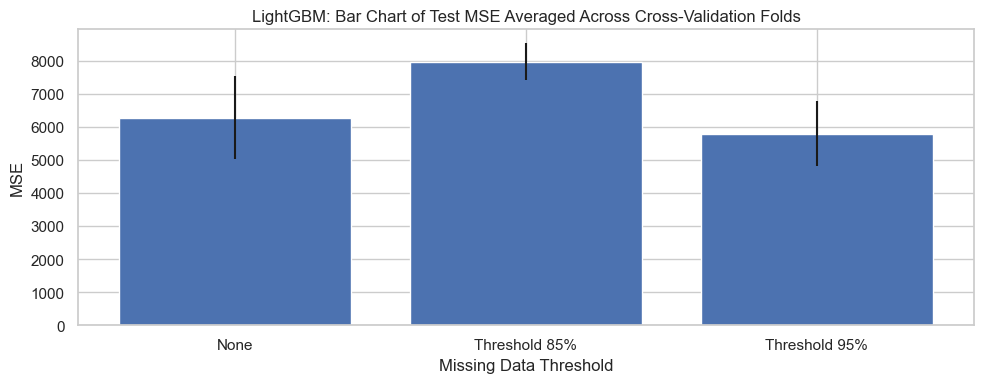

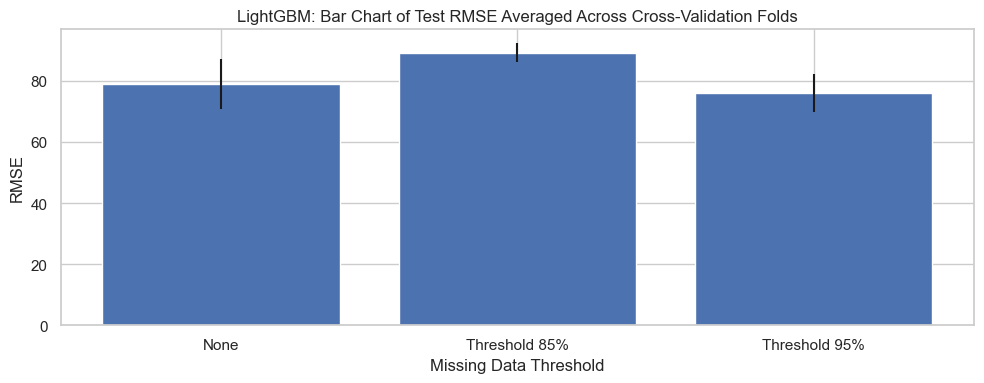

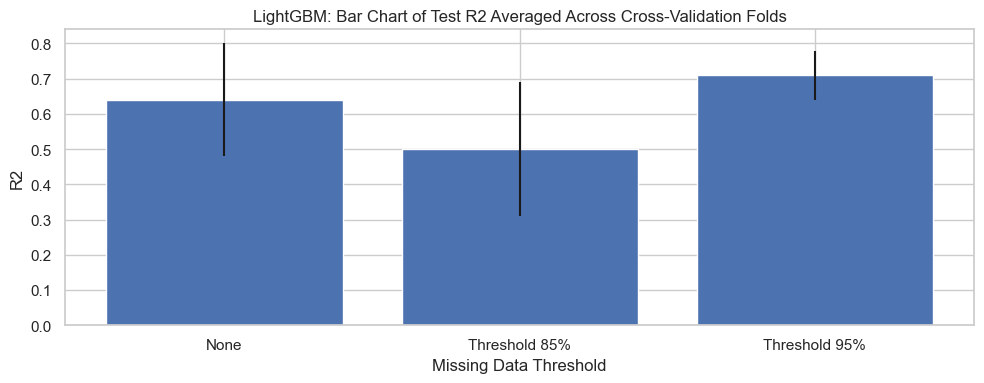

In [21]:
mean_data = mean_summary.astype(float)
std_data = std_summary.astype(float)

for metric in mean_data.columns:
    plt.figure(figsize=(10, 4))
    d_full = mean_data[metric]
    d = mean_data[metric].values
    e = std_data[metric].values
    plt.bar(d_full.index, d, yerr = e)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

In [66]:
mean_corr = mean_summary.corr()
mean_corr

,MAPE,MAE,MSE,RMSE,R2
MAPE,1.000000,0.982552,0.908998,0.905468,0.789203
MAE,0.982552,1.000000,0.970658,0.968605,0.661213
MSE,0.908998,0.970658,1.000000,0.999965,0.461414
RMSE,0.905468,0.968605,0.999965,1.000000,0.453952
R2,0.789203,0.661213,0.461414,0.453952,1.000000


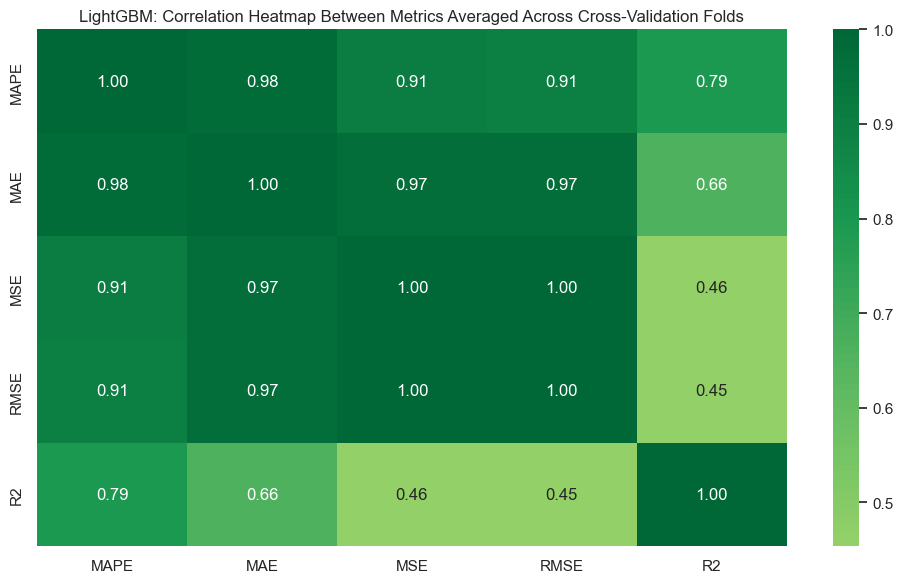

In [70]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("LightGBM: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds")
plt.tight_layout()
plt.show()

### extras